# K-Means *(and its extensions)*

TODO:
- feature selection / PCA for zoo dataset prediction
- mall prediction
- print or plot metrics vs param
- plot best hyperparameter combination
- other centroid-based methods? MeanShift?
- scatter plot that highlights differences

Note for future:

The paper [Clustering algorithms: A comparative approach](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0210236) did experiments with datasets that differ in number of features, classes, and number of objects per class.
For each algorithm, and each dataset, they reported metrics after experimenting with
1. default params
2. vary one, fix all other params
3. randomize all params

Datasets are available for download, we could use a subset?
We could choose 1 or 2 of the options above to test and analyze?

## Imports

In [113]:
# to prevent memory leak error when running Mini-Batch K-Means
import os
os.environ["OMP_NUM_THREADS"] = "1"

In [140]:
import pandas as pd
import numpy as np


from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import silhouette_score, adjusted_rand_score, davies_bouldin_score
from sklearn.model_selection import ParameterGrid
from sklearn.metrics.pairwise import pairwise_distances_argmin
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

import time

In [115]:
datasets = {
    "Spherical Clusters": pd.read_csv("./Datasets/Speherical_Clusters.csv"),
    "Moon Clusters": pd.read_csv("./Datasets/moons_Clusters.csv"),
    "Nested Clusters": pd.read_csv("./Datasets/Nested_Clusters.csv"),
    "Hierarchical Structure": pd.read_csv('./Datasets/Mall_Customers.csv'),
    "Hierarchical Structure (Zoo)": pd.read_csv('./Datasets/zoo.csv'),
}

## Utility functions / classes, constants

In [139]:
scaler = StandardScaler()
drop_enc = OneHotEncoder(drop="if_binary", sparse_output=False)


def preprocess(dataset_name):
    data = datasets[dataset_name]
    if dataset_name == "Hierarchical Structure":
        enc_gender = drop_enc.fit_transform(data[["Gender"]])
        scaled_numerical = scaler.fit_transform(
            data[["Age", "Annual Income (k$)", "Spending Score (1-100)"]]
        )
        X = np.hstack((enc_gender, scaled_numerical))
        y = None
    elif dataset_name == "Hierarchical Structure (Zoo)":
        X = data[["hair", "predator", "legs"]].to_numpy()
        y = data["class_type"].to_numpy()
    else:
        data = data.to_numpy()
        X = scaler.fit_transform(data[:, :-1])
        y = data[:, -1]

    return X, y

```Metrics``` class: stores all the metrics after running grid search for a single algorithm in a DataFrame.
- ```adjustable_params``` are set in [Grid search params](#grid-search-params).

In [150]:
class Metrics:
    """This class stores all the metrics after running grid search for a single algorithm in a DataFrame."""

    metrics_used = ["inertia", "silhouette", "ari", "davies-bouldin", "train_time"]

    def __init__(self, adjustable_params: list, X, y) -> None:
        """
        Args:
            adjustable_params (list): Parameters that are changed during grid search
            X (_type_): Input feature matrix
            y (_type_): Ground truth classes
        """

        df_cols = adjustable_params + [key for key in self.metrics_used]

        self.table = pd.DataFrame(columns=df_cols)
        self.X = X
        self.y = y

    @staticmethod
    def get_score(metric: str, X, y_true, y_pred):
        if metric == "silhouette":
            return silhouette_score(X=X, labels=y_pred)
        elif metric == "ari" and y_true is not None:  # ARI requires ground truth labels
            return adjusted_rand_score(labels_true=y_true, labels_pred=y_pred)
        elif metric == "davies-bouldin":
            return davies_bouldin_score(X=X, labels=y_pred)
        # elif metric == "jaccard":
        #     return jaccard_score(y_true=y_true, y_pred=y_pred, average="macro")
        # elif metric == "fm":
        #     return fowlkes_mallows_score(labels_true=y_true, labels_pred=y_pred)

    def add(self, params: dict, inertia, train_time, pred):
        new_row = {**params, "inertia": inertia, "train_time": train_time}

        for metric in self.metrics_used:
            if metric not in ["inertia", "train_time"]:
                new_row.update({metric: self.get_score(metric, self.X, self.y, pred)})

        self.table.loc[len(self.table.index)] = new_row

    def get_best(self, evaluated_metric: str):
        max_idx = self.table[evaluated_metric].idxmax()
        return self.table.iloc[max_idx]

    def get_df(self):
        return self.table

In [118]:
def plot_kmeans(
    ax,
    X: np.ndarray,
    y_out: np.ndarray,
    heading: str,
    centers: np.ndarray,
    metrics: dict = None,
):

    colors = [
        "tab:blue",
        "tab:orange",
        "tab:green",
        "tab:red",
        "tab:purple",
        "tab:brown",
        "tab:pink",
        "tab:gray",
        "tab:olive",
        "tab:cyan",
    ]

    # plot predicted clusters
    for k, col in zip(range(len(centers)), colors):
        ax.scatter(
            X[y_out == k, 0],
            X[y_out == k, 1],
            label=f"Cluster {int(k+1)}",
            c=col,
            alpha=0.6,
        )
    # plot centers of predicted clusters
    if (
        heading != "Ground Truth"
    ):  # TODO: remove this after we export centers with our datasets
        for ctr in centers:
            ax.plot(ctr[0], ctr[1], marker="X", c="k")
            ax.text(ctr[0], ctr[1], f"({ctr[0]:.3f}, {ctr[1]:.3f})")

    # show metrics for prediction
    if metrics is not None:
        text = ""
        for k, v in metrics.items():
            text += f"{k} = {v:.5f}\n"
        ax.text(
            0.1,
            0.01,
            text,
            verticalalignment="bottom",
            horizontalalignment="left",
            transform=ax.transAxes,
        )

    ax.set_title(heading)
    ax.legend()

    return ax

In [199]:
def plot_kmeans_3d(
    fig: go.Figure,
    pos,
    X: np.ndarray,
    y_out: np.ndarray,
    heading: str,
    centers: np.ndarray,
    metrics: dict = None,
):

    colors = [
        "#1f77b4",
        "#ff7f0e",
        "#2ca02c",
        "#d62728",
        "#9467bd",
        "#8c564b",
        "#e377c2",
        "#7f7f7f",
        "#bcbd22",
        "#17becf",
    ]

    if y_out is None:
        y_out = np.zeros(X.shape[0])

    # plot predicted clusters
    for k, col in zip(range(len(centers)), colors):
        fig.add_trace(
            go.Scatter3d(
                x=X[y_out == k, 0],
                y=X[y_out == k, 1],
                z=X[y_out == k, 2],
                mode="markers",
                marker=dict(
                    size=5,
                    color=col,  # set color to an array/list of desired values
                    opacity=0.6,
                ),
            ),
            row=pos[0],
            col=pos[1],
        )

    # plot centers of predicted clusters
    if (
        heading != "Ground Truth"
    ):  # TODO: remove this after we export centers with our datasets
        fig.add_trace(
            go.Scatter3d(
                x=centers[:, 0],
                y=centers[:, 1],
                z=centers[:, 2],
                mode="markers",
                # text=[f"({ctr[0]:.3f}, {ctr[1]:.3f}, {ctr[1]:.3f})" for ctr in centers],
                # text=[f"C{i}" for i in range(len(centers))],
                textposition="top center",
                marker=dict(
                    size=3,
                    color=[colors[i] for i in range(len(centers))],
                    symbol=["x" for _ in range(len(centers))],
                ),
            ),
            row=pos[0],
            col=pos[1],
        )

    # show metrics for prediction
    if metrics is not None:
        text = ""
        for k, v in metrics.items():
            text += f"{k} = {v:.5f}\n"
        fig.update_annotations(
            text=text,
            xref=f"x{pos[0] if pos[0]>1 else'' }",
            yref=f"y{pos[1] if pos[1]>1 else ''}",
        )

In [120]:
def run_kmeans(X, params):
    if "batch_size" in params:
        model = MiniBatchKMeans(**params)
    else:
        model = KMeans(**params)
    t_start = time.time()
    labels = model.fit_predict(X)
    t_elapsed = time.time() - t_start

    return labels, model, t_elapsed

In [121]:
def run_grid(test_params, param_grid, X, y) -> pd.DataFrame:
    """Runs grid search without cross validation folds

    Args:
        test_params (_type_): _description_
        param_grid (_type_): _description_
        X (_type_): _description_
        y (_type_): _description_

    Returns:
        pd.DataFrame: Stored metrics
    """

    metrics = Metrics(
        adjustable_params=[key for key in test_params if len(test_params[key]) > 1],
        X=X,
        y=y,
    )

    for params in param_grid:
        pred, model, t_elapsed = run_kmeans(X, params)
        metrics.add(params, model.inertia_, t_elapsed, pred)

    return metrics.get_df()

### Default parameters
Used to plot default clustering for comparison across algorithms

In [122]:
km_default_params = {
    "n_clusters": 8,
    "init": "k-means++",
    "n_init": 10,
    "max_iter": 300,
    "random_state": 0,
    "tol": 0.0001,
    "algorithm": "lloyd",
}

mbkm_default_params = {
    "n_clusters": 8,
    "init": "k-means++",
    "n_init": 10,
    "max_iter": 300,  # default is 100, but we set it to be the same as Mini-Batch for a fairer comparison
    "batch_size": 500,  # default is 1024, but we set it to 500 since our test datasets have a size of 1000 only
    "random_state": 0,
    "tol": 0.0,
    "max_no_improvement": 10,
    "init_size": None,
    "reassignment_ratio": 0.01,
}

### Function for plotting of inertia and silhouette scores
based on default parameters

In [123]:
def plot_optimal_k(ax1, ax2, model, metrics_df: pd.DataFrame):

    if model == "Mini-Batch K-Means++":
        default_params = mbkm_default_params
    else:
        default_params = km_default_params

    match_dict = {
        p: v
        for p, v in default_params.items()
        if p in metrics_df.columns and p != "n_clusters"
    }
    mask = (metrics_df[list(match_dict)] == pd.Series(match_dict)).all(axis=1)
    subset = metrics_df[mask]

    ax1.plot(
        subset["n_clusters"], subset["inertia"], label=f"{model}", alpha=0.6, marker="."
    )


    ax2.plot(
        subset["n_clusters"],
        subset["silhouette"],
        label=f"{model}",
        alpha=0.6,
        marker=".",
    )


    ax1.set_xlabel("n_clusters")
    ax1.set_ylabel("Inertia")
    ax1.set_title("Elbow Plot")
    ax1.legend()


    ax2.set_xlabel("n_clusters")
    ax2.set_ylabel("Silhouette Score")
    ax2.set_title("Silhouette Analysis")
    ax2.legend()

### Grid search params

In [124]:
km_test_params = {
    "n_clusters": [_ for _ in range(2, 11)],
    "init": ["random"],
    "n_init": [1, 5, 10],
    "random_state": [0],
    "max_iter": [100, 300, 800],
}
km_param_grid = ParameterGrid(km_test_params)

kmpp_test_params = {
    "n_clusters": [_ for _ in range(2, 11)],
    "init": ["k-means++"],
    "n_init": [1, 5, 10],
    "random_state": [0],
    "max_iter": [100, 300, 800],
}
kmpp_param_grid = ParameterGrid(kmpp_test_params)

mbkm_test_params = {
    "n_clusters": [_ for _ in range(2, 11)],
    "init": ["k-means++"],
    "max_iter": [100, 300, 800],
    "batch_size": [50, 100, 500],
    "random_state": [0],
    "n_init": [1, 5, 10],
    "reassignment_ratio": [0.01, 0.05],
    "max_no_improvement": [None, 10],
}
mbkm_param_grid = ParameterGrid(mbkm_test_params)

For each dataset, we first find the optimal $k$ number of clusters (```n_clusters```), run GridSearch and record metrics, then plot the predicted clustering for default and best hyperparameters*(TODO)

## 1. Spherical Clusters

In [75]:
data_name = "Spherical Clusters"
X, y = preprocess(data_name)

# do grid search on each model, but without folds to ensure consistency with the other notebooks
# just added this in case it's useful for further experimentation with different dataset sizes

km_sphere_df = run_grid(km_test_params, km_param_grid, X, y)
kmpp_sphere_df = run_grid(kmpp_test_params, kmpp_param_grid, X, y)
mbkm_sphere_df = run_grid(mbkm_test_params, mbkm_param_grid, X, y)

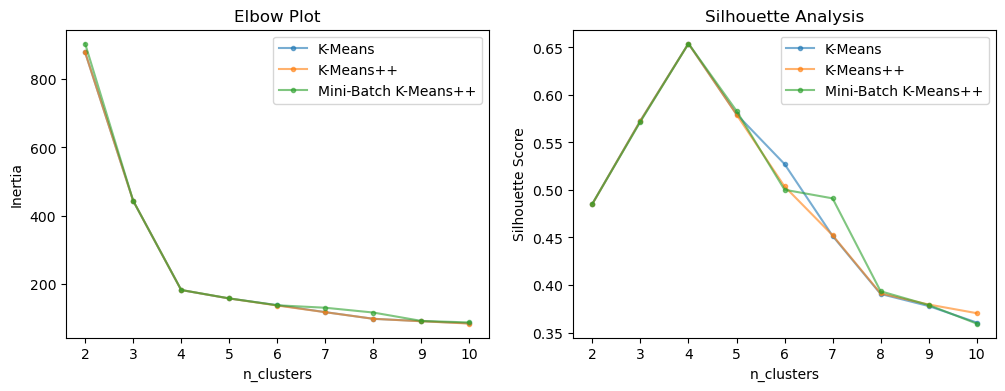

In [76]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

plot_optimal_k(axs[0], axs[1], "K-Means", km_sphere_df)
plot_optimal_k(axs[0], axs[1], "K-Means++", kmpp_sphere_df)
plot_optimal_k(axs[0], axs[1], "Mini-Batch K-Means++", mbkm_sphere_df)

With spherical data, we can determine the optimal number of clusters using an elbow plot of inertia values.

In [77]:
# Set the default params for all models to run, giving them the ground truth number of clusters as input

num_clusters = len(np.unique(y))

km_params = km_default_params.copy()
km_params["n_clusters"] = num_clusters
km_params["init"] = "random"
# km_params["n_init"] = "auto"

kmpp_params = km_default_params.copy()
kmpp_params["n_clusters"] = num_clusters

mbkm_params = mbkm_default_params.copy()
mbkm_params["n_clusters"] = num_clusters

In [78]:
km_y_pred, kmeans, km_train_time = run_kmeans(X, km_params)
kmpp_y_pred, kmeanspp, kmpp_train_time = run_kmeans(X, kmpp_params)
mbkm_y_pred, mbkmeans, mbkm_train_time = run_kmeans(X, mbkm_params)

In [79]:
# ensure clusters are colored in the same order for easier comparison across algorithms

kmeans_cluster_centers = kmeans.cluster_centers_
order = pairwise_distances_argmin(kmeans.cluster_centers_, kmeanspp.cluster_centers_)
kmeanspp_cluster_centers = kmeanspp.cluster_centers_[order]
order = pairwise_distances_argmin(kmeans.cluster_centers_, mbkmeans.cluster_centers_)
mbkmeans_cluster_centers = mbkmeans.cluster_centers_[order]

km_labels = pairwise_distances_argmin(X, kmeans_cluster_centers)
kmpp_labels = pairwise_distances_argmin(X, kmeanspp_cluster_centers)
mbkm_labels = pairwise_distances_argmin(X, mbkmeans_cluster_centers)

Vanilla K-Means parameters: {'n_clusters': 4, 'init': 'random', 'n_init': 10, 'max_iter': 300, 'random_state': 0, 'tol': 0.0001, 'algorithm': 'lloyd'}
K-Means++ parameters: {'n_clusters': 4, 'init': 'k-means++', 'n_init': 10, 'max_iter': 300, 'random_state': 0, 'tol': 0.0001, 'algorithm': 'lloyd'}
Mini-Batch K-Means++ parameters: {'n_clusters': 4, 'init': 'k-means++', 'n_init': 10, 'max_iter': 300, 'batch_size': 500, 'random_state': 0, 'tol': 0.0, 'max_no_improvement': 10, 'init_size': None, 'reassignment_ratio': 0.01}


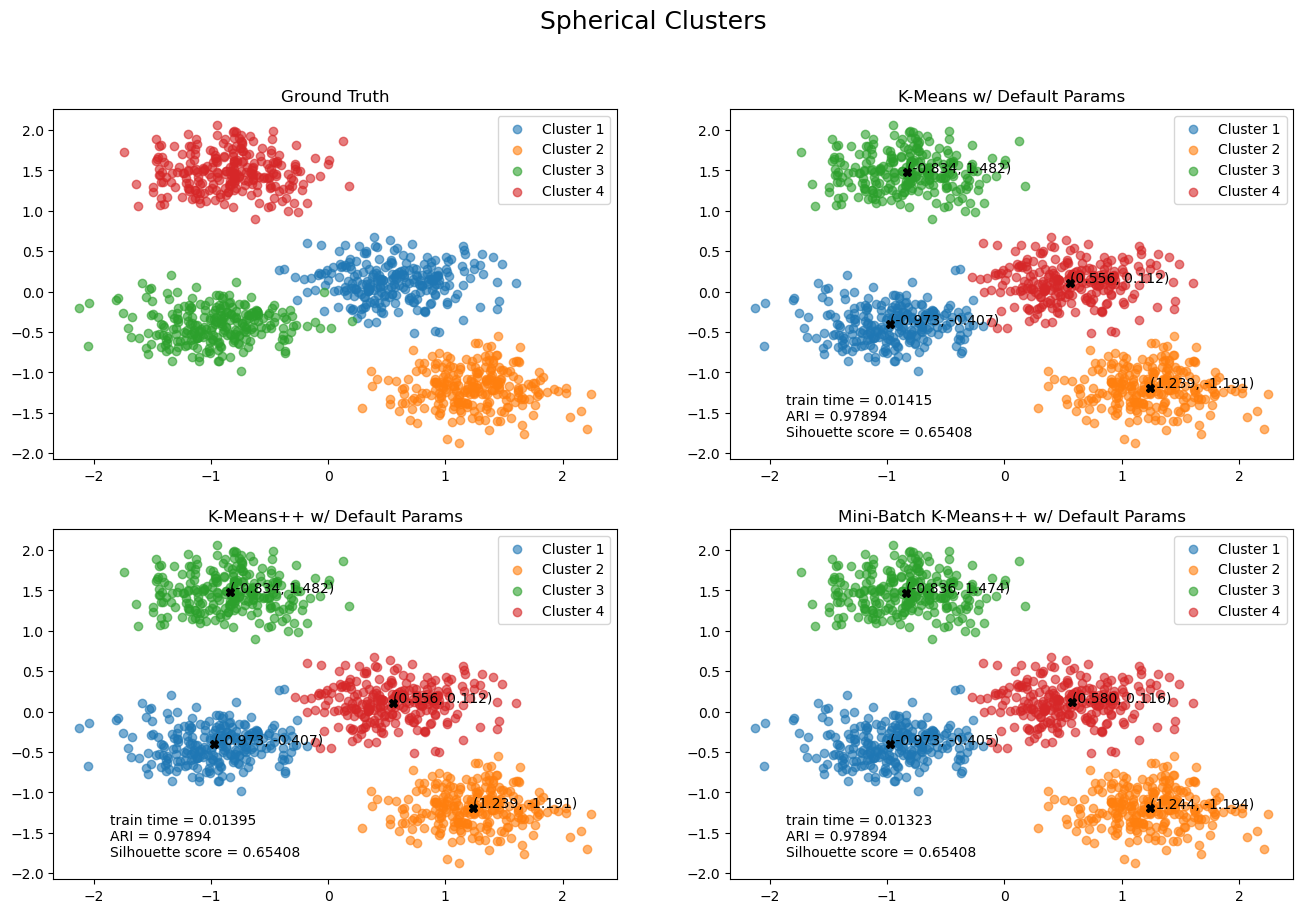

In [80]:
print(f"Vanilla K-Means parameters: {km_params}")
print(f"K-Means++ parameters: {kmpp_params}")
print(f"Mini-Batch K-Means++ parameters: {mbkm_params}")

fig, axs = plt.subplots(2, 2, figsize=(16, 10))

plot_kmeans(
    ax=axs[0, 0], X=X, y_out=y, heading="Ground Truth", centers=np.zeros(4)
)  # TODO: input actual centers when available


plot_kmeans(
    ax=axs[0, 1],
    X=X,
    y_out=km_labels,
    heading="K-Means w/ Default Params",
    centers=kmeans.cluster_centers_,
    metrics={
        "train time": km_train_time,
        "ARI": Metrics.get_score("ari", X, y, km_y_pred),
        "Sihouette score": Metrics.get_score("silhouette", X, y, km_y_pred),
    },
)


plot_kmeans(
    ax=axs[1, 0],
    X=X,
    y_out=kmpp_labels,
    heading="K-Means++ w/ Default Params",
    centers=kmeanspp.cluster_centers_,
    metrics={
        "train time": kmpp_train_time,
        "ARI": Metrics.get_score("ari", X, y, kmpp_y_pred),
        "Silhouette score": Metrics.get_score("silhouette", X, y, kmpp_y_pred),
    },
)

plot_kmeans(
    ax=axs[1, 1],
    X=X,
    y_out=mbkm_labels,
    heading="Mini-Batch K-Means++ w/ Default Params",
    centers=mbkmeans.cluster_centers_,
    metrics={
        "train time": mbkm_train_time,
        "ARI": Metrics.get_score("ari", X, y, mbkm_y_pred),
        "Silhouette score": Metrics.get_score("silhouette", X, y, mbkm_y_pred),
    },
)


fig.suptitle(data_name, fontsize=18)


plt.show()

### Observations
- K-Means++ runs faster than vanilla K-Means
- Here, ```max_iter=300```: mini-batch K-Means takes the shortest time to train.
- When tested with ```max_iter=100```: Though we would expect Mini-Batch K-Means++ to train faster than regular K-Means, in our rather small dataset of 1000 samples, the overhead caused by the extra iterations (in this case, since we set ```batch_size=500```, there are a total of 2 iterations) outweighed the benefit of using mini-batches.

## 2. Moon Clusters

In [81]:
data_name = "Moon Clusters"
X, y = preprocess(data_name)

# do grid search on each model, but without folds to ensure consistency with the other notebooks
# just added this in case it's useful for further experimentation with different dataset sizes

km_sphere_df = run_grid(km_test_params, km_param_grid, X, y)
kmpp_sphere_df = run_grid(kmpp_test_params, kmpp_param_grid, X, y)
mbkm_sphere_df = run_grid(mbkm_test_params, mbkm_param_grid, X, y)

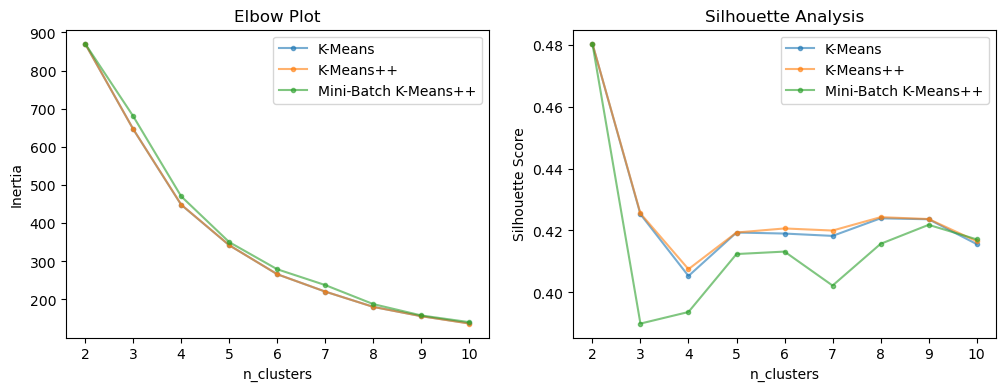

In [82]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

plot_optimal_k(axs[0], axs[1], "K-Means", km_sphere_df)
plot_optimal_k(axs[0], axs[1], "K-Means++", kmpp_sphere_df)
plot_optimal_k(axs[0], axs[1], "Mini-Batch K-Means++", mbkm_sphere_df)

In [83]:
# Set the default params for all models to run, giving them the ground truth number of clusters as input

num_clusters = len(np.unique(y))

km_params = km_default_params.copy()
km_params["n_clusters"] = num_clusters
km_params["init"] = "random"
# km_params["n_init"] = "auto"

kmpp_params = km_default_params.copy()
kmpp_params["n_clusters"] = num_clusters

mbkm_params = mbkm_default_params.copy()
mbkm_params["n_clusters"] = num_clusters

In [84]:
km_y_pred, kmeans, km_train_time = run_kmeans(X, km_params)
kmpp_y_pred, kmeanspp, kmpp_train_time = run_kmeans(X, kmpp_params)
mbkm_y_pred, mbkmeans, mbkm_train_time = run_kmeans(X, mbkm_params)

In [85]:
# ensure clusters are colored in the same order for easier comparison across algorithms

kmeans_cluster_centers = kmeans.cluster_centers_
order = pairwise_distances_argmin(kmeans.cluster_centers_, kmeanspp.cluster_centers_)
kmeanspp_cluster_centers = kmeanspp.cluster_centers_[order]
order = pairwise_distances_argmin(kmeans.cluster_centers_, mbkmeans.cluster_centers_)
mbkmeans_cluster_centers = mbkmeans.cluster_centers_[order]

km_labels = pairwise_distances_argmin(X, kmeans_cluster_centers)
kmpp_labels = pairwise_distances_argmin(X, kmeanspp_cluster_centers)
mbkm_labels = pairwise_distances_argmin(X, mbkmeans_cluster_centers)

Vanilla K-Means parameters: {'n_clusters': 2, 'init': 'random', 'n_init': 10, 'max_iter': 300, 'random_state': 0, 'tol': 0.0001, 'algorithm': 'lloyd'}
K-Means++ parameters: {'n_clusters': 2, 'init': 'k-means++', 'n_init': 10, 'max_iter': 300, 'random_state': 0, 'tol': 0.0001, 'algorithm': 'lloyd'}
Mini-Batch K-Means++ parameters: {'n_clusters': 2, 'init': 'k-means++', 'n_init': 10, 'max_iter': 300, 'batch_size': 500, 'random_state': 0, 'tol': 0.0, 'max_no_improvement': 10, 'init_size': None, 'reassignment_ratio': 0.01}


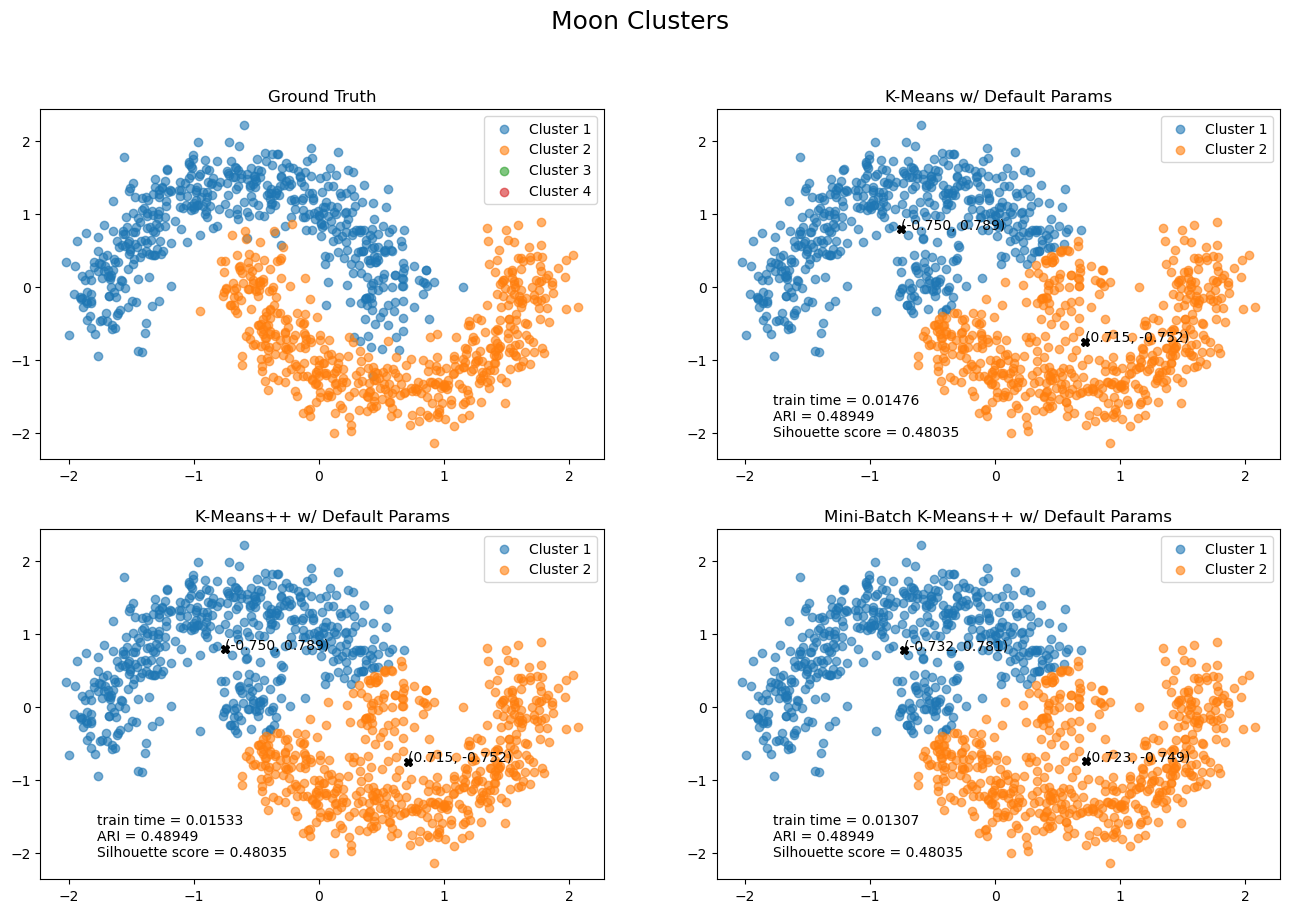

In [86]:
print(f"Vanilla K-Means parameters: {km_params}")
print(f"K-Means++ parameters: {kmpp_params}")
print(f"Mini-Batch K-Means++ parameters: {mbkm_params}")

fig, axs = plt.subplots(2, 2, figsize=(16, 10))

plot_kmeans(
    ax=axs[0, 0], X=X, y_out=y, heading="Ground Truth", centers=np.zeros(4)
)  # TODO: input actual centers when available


plot_kmeans(
    ax=axs[0, 1],
    X=X,
    y_out=km_labels,
    heading="K-Means w/ Default Params",
    centers=kmeans.cluster_centers_,
    metrics={
        "train time": km_train_time,
        "ARI": Metrics.get_score("ari", X, y, km_y_pred),
        "Sihouette score": Metrics.get_score("silhouette", X, y, km_y_pred),
    },
)


plot_kmeans(
    ax=axs[1, 0],
    X=X,
    y_out=kmpp_labels,
    heading="K-Means++ w/ Default Params",
    centers=kmeanspp.cluster_centers_,
    metrics={
        "train time": kmpp_train_time,
        "ARI": Metrics.get_score("ari", X, y, kmpp_y_pred),
        "Silhouette score": Metrics.get_score("silhouette", X, y, kmpp_y_pred),
    },
)

plot_kmeans(
    ax=axs[1, 1],
    X=X,
    y_out=mbkm_labels,
    heading="Mini-Batch K-Means++ w/ Default Params",
    centers=mbkmeans.cluster_centers_,
    metrics={
        "train time": mbkm_train_time,
        "ARI": Metrics.get_score("ari", X, y, mbkm_y_pred),
        "Silhouette score": Metrics.get_score("silhouette", X, y, mbkm_y_pred),
    },
)


fig.suptitle(data_name, fontsize=18)


plt.show()

### Observations
- It is difficult to determine an optimal number of clusters using the elbow plot of inertia values
- K-Means does not work well on non-spherical clusters

## 3. Nested Clusters

In [87]:
data_name = "Nested Clusters"
X, y = preprocess(data_name)

# do grid search on each model, but without folds to ensure consistency with the other notebooks
# just added this in case it's useful for further experimentation with different dataset sizes

km_sphere_df = run_grid(km_test_params, km_param_grid, X, y)
kmpp_sphere_df = run_grid(kmpp_test_params, kmpp_param_grid, X, y)
mbkm_sphere_df = run_grid(mbkm_test_params, mbkm_param_grid, X, y)

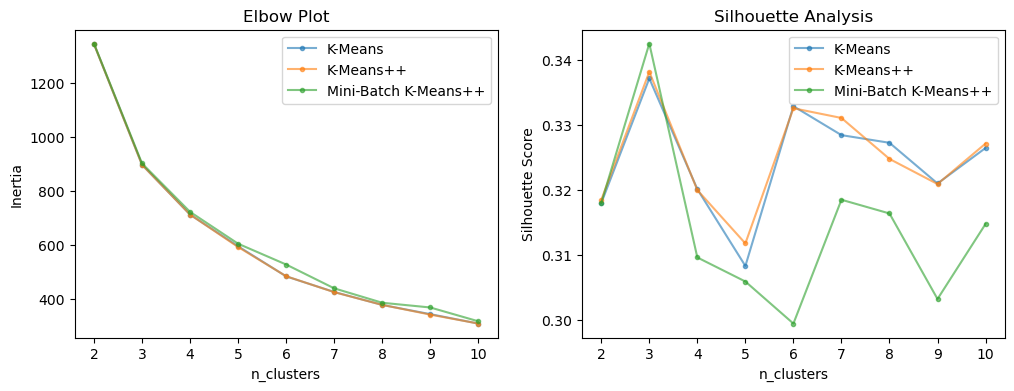

In [88]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

plot_optimal_k(axs[0], axs[1], "K-Means", km_sphere_df)
plot_optimal_k(axs[0], axs[1], "K-Means++", kmpp_sphere_df)
plot_optimal_k(axs[0], axs[1], "Mini-Batch K-Means++", mbkm_sphere_df)

In [89]:
# Set the default params for all models to run, giving them the ground truth number of clusters as input

num_clusters = len(np.unique(y))

km_params = km_default_params.copy()
km_params["n_clusters"] = num_clusters
km_params["init"] = "random"
# km_params["n_init"] = "auto"

kmpp_params = km_default_params.copy()
kmpp_params["n_clusters"] = num_clusters

mbkm_params = mbkm_default_params.copy()
mbkm_params["n_clusters"] = num_clusters

In [90]:
km_y_pred, kmeans, km_train_time = run_kmeans(X, km_params)
kmpp_y_pred, kmeanspp, kmpp_train_time = run_kmeans(X, kmpp_params)
mbkm_y_pred, mbkmeans, mbkm_train_time = run_kmeans(X, mbkm_params)

In [91]:
# ensure clusters are colored in the same order for easier comparison across algorithms

kmeans_cluster_centers = kmeans.cluster_centers_
order = pairwise_distances_argmin(kmeans.cluster_centers_, kmeanspp.cluster_centers_)
kmeanspp_cluster_centers = kmeanspp.cluster_centers_[order]
order = pairwise_distances_argmin(kmeans.cluster_centers_, mbkmeans.cluster_centers_)
mbkmeans_cluster_centers = mbkmeans.cluster_centers_[order]

km_labels = pairwise_distances_argmin(X, kmeans_cluster_centers)
kmpp_labels = pairwise_distances_argmin(X, kmeanspp_cluster_centers)
mbkm_labels = pairwise_distances_argmin(X, mbkmeans_cluster_centers)

Vanilla K-Means parameters: {'n_clusters': 3, 'init': 'random', 'n_init': 10, 'max_iter': 300, 'random_state': 0, 'tol': 0.0001, 'algorithm': 'lloyd'}
K-Means++ parameters: {'n_clusters': 3, 'init': 'k-means++', 'n_init': 10, 'max_iter': 300, 'random_state': 0, 'tol': 0.0001, 'algorithm': 'lloyd'}
Mini-Batch K-Means++ parameters: {'n_clusters': 3, 'init': 'k-means++', 'n_init': 10, 'max_iter': 300, 'batch_size': 500, 'random_state': 0, 'tol': 0.0, 'max_no_improvement': 10, 'init_size': None, 'reassignment_ratio': 0.01}


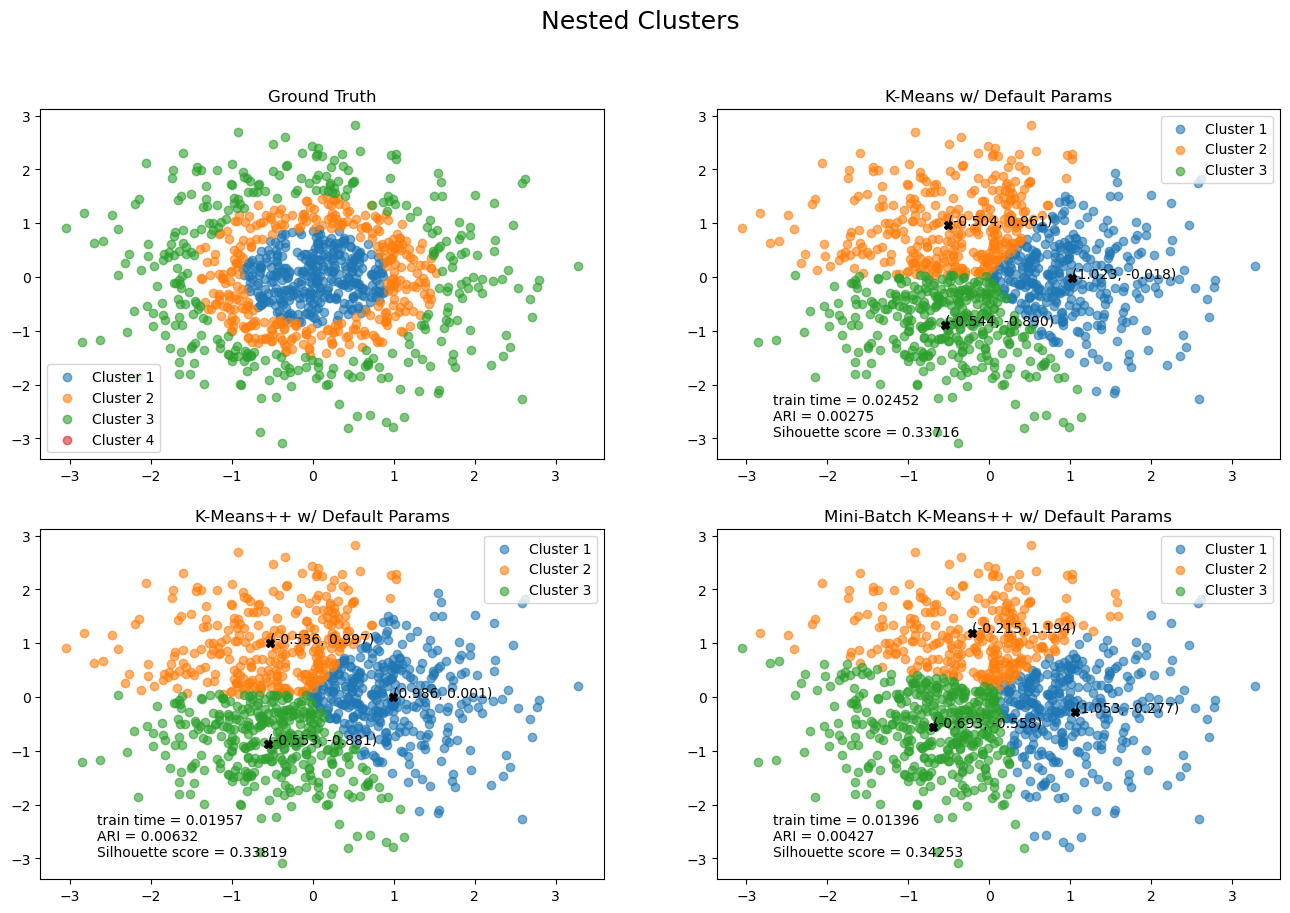

In [92]:
print(f"Vanilla K-Means parameters: {km_params}")
print(f"K-Means++ parameters: {kmpp_params}")
print(f"Mini-Batch K-Means++ parameters: {mbkm_params}")

fig, axs = plt.subplots(2, 2, figsize=(16, 10))

plot_kmeans(
    ax=axs[0, 0], X=X, y_out=y, heading="Ground Truth", centers=np.zeros(4)
)  # TODO: input actual centers when available


plot_kmeans(
    ax=axs[0, 1],
    X=X,
    y_out=km_labels,
    heading="K-Means w/ Default Params",
    centers=kmeans.cluster_centers_,
    metrics={
        "train time": km_train_time,
        "ARI": Metrics.get_score("ari", X, y, km_y_pred),
        "Sihouette score": Metrics.get_score("silhouette", X, y, km_y_pred),
    },
)


plot_kmeans(
    ax=axs[1, 0],
    X=X,
    y_out=kmpp_labels,
    heading="K-Means++ w/ Default Params",
    centers=kmeanspp.cluster_centers_,
    metrics={
        "train time": kmpp_train_time,
        "ARI": Metrics.get_score("ari", X, y, kmpp_y_pred),
        "Silhouette score": Metrics.get_score("silhouette", X, y, kmpp_y_pred),
    },
)

plot_kmeans(
    ax=axs[1, 1],
    X=X,
    y_out=mbkm_labels,
    heading="Mini-Batch K-Means++ w/ Default Params",
    centers=mbkmeans.cluster_centers_,
    metrics={
        "train time": mbkm_train_time,
        "ARI": Metrics.get_score("ari", X, y, mbkm_y_pred),
        "Silhouette score": Metrics.get_score("silhouette", X, y, mbkm_y_pred),
    },
)


fig.suptitle(data_name, fontsize=18)


plt.show()

### Observations
- K-Means does not work well on clusters of uneven variances

## 4. Hierarchical Structure

In [151]:
data_name = "Hierarchical Structure"
X, y = preprocess(data_name)

# do grid search on each model, but without folds to ensure consistency with the other notebooks
# just added this in case it's useful for further experimentation with different dataset sizes

km_sphere_df = run_grid(km_test_params, km_param_grid, X, y)
kmpp_sphere_df = run_grid(kmpp_test_params, kmpp_param_grid, X, y)
mbkm_sphere_df = run_grid(mbkm_test_params, mbkm_param_grid, X, y)

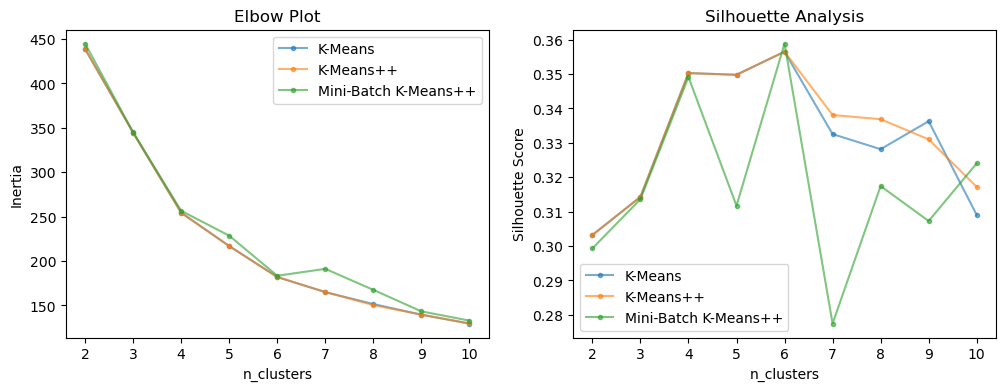

In [153]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

plot_optimal_k(axs[0], axs[1], "K-Means", km_sphere_df)
plot_optimal_k(axs[0], axs[1], "K-Means++", kmpp_sphere_df)
plot_optimal_k(axs[0], axs[1], "Mini-Batch K-Means++", mbkm_sphere_df)

In [158]:
# Set the default params for all models to run

num_clusters = 6 # based on elbow plot and silhouette scores since we don't have ground truth labels for this dataset

km_params = km_default_params.copy()
km_params["n_clusters"] = num_clusters
km_params["init"] = "random"
# km_params["n_init"] = "auto"

kmpp_params = km_default_params.copy()
kmpp_params["n_clusters"] = num_clusters

mbkm_params = mbkm_default_params.copy()
mbkm_params["n_clusters"] = num_clusters

In [159]:
km_y_pred, kmeans, km_train_time = run_kmeans(X, km_params)
kmpp_y_pred, kmeanspp, kmpp_train_time = run_kmeans(X, kmpp_params)
mbkm_y_pred, mbkmeans, mbkm_train_time = run_kmeans(X, mbkm_params)

In [160]:
# ensure clusters are colored in the same order for easier comparison across algorithms

kmeans_cluster_centers = kmeans.cluster_centers_
order = pairwise_distances_argmin(kmeans.cluster_centers_, kmeanspp.cluster_centers_)
kmeanspp_cluster_centers = kmeanspp.cluster_centers_[order]
order = pairwise_distances_argmin(kmeans.cluster_centers_, mbkmeans.cluster_centers_)
mbkmeans_cluster_centers = mbkmeans.cluster_centers_[order]

km_labels = pairwise_distances_argmin(X, kmeans_cluster_centers)
kmpp_labels = pairwise_distances_argmin(X, kmeanspp_cluster_centers)
mbkm_labels = pairwise_distances_argmin(X, mbkmeans_cluster_centers)

In [200]:
print(f"Vanilla K-Means parameters: {km_params}")
print(f"K-Means++ parameters: {kmpp_params}")
print(f"Mini-Batch K-Means++ parameters: {mbkm_params}")

rows = 2
cols = 2

fig = make_subplots(
    rows,
    cols,
    subplot_titles=(
        "Ground Truth",
        "K-Means w/ Default Params",
        "K-Means++ w/ Default Params",
        "Mini-Batch K-Means++ w/ Default Params",
    ),
    specs=[[{"type": "scene"} for _ in range(cols)] for _ in range(rows)],
)

# Models were fit with all features, but in this 3D plot,
# we exclude Gender and only show the 3 continuous features

plot_kmeans_3d(
    fig, pos=(1, 1), X=X[:, 1:], y_out=y, heading="Ground Truth", centers=np.zeros(4)
)  # TODO: input actual centers when available


plot_kmeans_3d(
    fig,
    pos=(1, 2),
    X=X[:, 1:],
    y_out=km_labels,
    heading="K-Means w/ Default Params",
    centers=kmeans.cluster_centers_,
    metrics={
        "train time": km_train_time,
        "Davies-Bouldin": Metrics.get_score("davies-bouldin", X, y, km_y_pred),
        "Sihouette score": Metrics.get_score("silhouette", X, y, km_y_pred),
    },
)


plot_kmeans_3d(
    fig,
    pos=(2, 1),
    X=X[:, 1:],
    y_out=kmpp_labels,
    heading="K-Means++ w/ Default Params",
    centers=kmeanspp.cluster_centers_,
    metrics={
        "train time": kmpp_train_time,
        "Davies-Bouldin": Metrics.get_score("davies-bouldin", X, y, kmpp_y_pred),
        "Silhouette score": Metrics.get_score("silhouette", X, y, kmpp_y_pred),
    },
)

plot_kmeans_3d(
    fig,
    pos=(2, 2),
    X=X[:, 1:],
    y_out=mbkm_labels,
    heading="Mini-Batch K-Means++ w/ Default Params",
    centers=mbkmeans.cluster_centers_,
    metrics={
        "train time": mbkm_train_time,
        "Davies-Bouldin": Metrics.get_score("davies-bouldin", X, y, mbkm_y_pred),
        "Silhouette score": Metrics.get_score("silhouette", X, y, mbkm_y_pred),
    },
)


fig.update_scenes(
    xaxis_title_text="Age",
    yaxis_title_text="Annual Income (k$)",
    zaxis_title_text="Spending Score (1-100)",
    camera_eye_z=0.5,
)
fig.update_layout(
    title_text=data_name,
    height=800,
    width=1000,
    showlegend=False,
)

Vanilla K-Means parameters: {'n_clusters': 6, 'init': 'random', 'n_init': 10, 'max_iter': 300, 'random_state': 0, 'tol': 0.0001, 'algorithm': 'lloyd'}
K-Means++ parameters: {'n_clusters': 6, 'init': 'k-means++', 'n_init': 10, 'max_iter': 300, 'random_state': 0, 'tol': 0.0001, 'algorithm': 'lloyd'}
Mini-Batch K-Means++ parameters: {'n_clusters': 6, 'init': 'k-means++', 'n_init': 10, 'max_iter': 300, 'batch_size': 500, 'random_state': 0, 'tol': 0.0, 'max_no_improvement': 10, 'init_size': None, 'reassignment_ratio': 0.01}
